In [27]:
# %%
import torch
import torch.nn.functional as F
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Libraries specific to YOLO and Grad-CAM
from ultralytics import YOLO
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [28]:
model_path = "../model/sheep-detector+preprocessing+augmentation.pt"
model = YOLO(model_path)
model_torch = model.model
model_torch.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_torch.to(device) # Move the model to the selected device

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3k2(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
   

In [29]:
def yolov8_reshape_transform(activations):
    """
    Reshapes and combines activations from multiple FPN layers for YOLOv8/v11.
    This is crucial because EigenCAM expects a single tensor, but YOLO's FPN
    produces multiple feature maps at different scales.
    Args:
        activations (list of torch.Tensor): List of feature maps from target_layers.
                                            Each tensor shape: (B, C, H, W)
    Returns:
        torch.Tensor: A single combined feature map of shape (B, C, H_max, W_max)
                      obtained by resizing and averaging.
    """
    if not isinstance(activations, (list, tuple)):
        # If it's already a single tensor (e.g., if only one target_layer), return it.
        return activations

    # Determine the target size (H, W) from the largest feature map
    # Assuming activations are ordered from largest to smallest spatial size or pick the first.
    target_size = activations[0].shape[2:]

    # Resize all feature maps to the target size and then average them.
    resized_activations = []
    for act in activations:
        if act.shape[2:] != target_size:
            # Resize using bilinear interpolation for smoothness
            act = F.interpolate(act, size=target_size, mode='bilinear', align_corners=False)
        resized_activations.append(act)
    
    # Stack the resized activations and then compute the mean across the stacked dimension.
    combined_activations = torch.mean(torch.stack(resized_activations), dim=0)
    return combined_activations

In [30]:
target_layers = [model_torch.model[19]]
print(f"Target layer(s) for EigenCAM: {[layer.__class__.__name__ for layer in target_layers]}")

Target layer(s) for EigenCAM: ['C3k2']


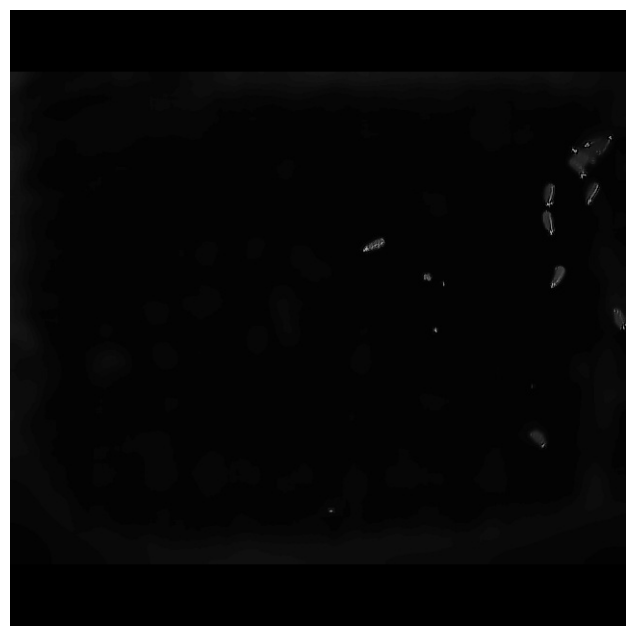

In [31]:
image_path = "../dataset/images/test/DJI_20240125160748_0073_T.JPG"
original_img = Image.open(image_path).convert('RGB')
original_img_np = np.array(original_img)
img_resized = original_img.resize((640, 640))
img_np = np.array(img_resized)

plt.figure(figsize=(8, 8))
plt.imshow(original_img_np)
plt.axis('off')
plt.show()

In [32]:
input_tensor = torch.from_numpy(img_np).float() / 255.0
input_tensor = input_tensor.permute(2, 0, 1).unsqueeze(0) # Add batch dimension
input_tensor = input_tensor.to(device)

print(f"Original image shape: {original_img_np.shape}")
print(f"Input tensor shape for model: {input_tensor.shape}")

Original image shape: (640, 640, 3)
Input tensor shape for model: torch.Size([1, 3, 640, 640])


In [33]:
results = model(input_tensor, verbose=False)

cam = EigenCAM(model=model_torch,
               target_layers=target_layers,
               reshape_transform=yolov8_reshape_transform,
            )

In [34]:
heatmap = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(0)])[0, :, :]

print(f"Heatmap min (from EigenCAM): {heatmap.min():.4f}")
print(f"Heatmap max (from EigenCAM): {heatmap.max():.4f}")

Heatmap min (from EigenCAM): 0.0000
Heatmap max (from EigenCAM): 1.0000


In [35]:
heatmap_np = heatmap 

original_h, original_w = original_img_np.shape[0], original_img_np.shape[1]
heatmap_resized = cv2.resize(heatmap_np, (original_w, original_h))

# heatmap_resized = 1 - heatmap_resized

heatmap_colored = np.uint8(255 * heatmap_resized)
heatmap_colored = cv2.applyColorMap(heatmap_colored, cv2.COLORMAP_JET)

alpha = 0.4 
superimposed_img = (original_img_np * (1 - alpha)) + (heatmap_colored * alpha)
superimposed_img = np.uint8(superimposed_img)

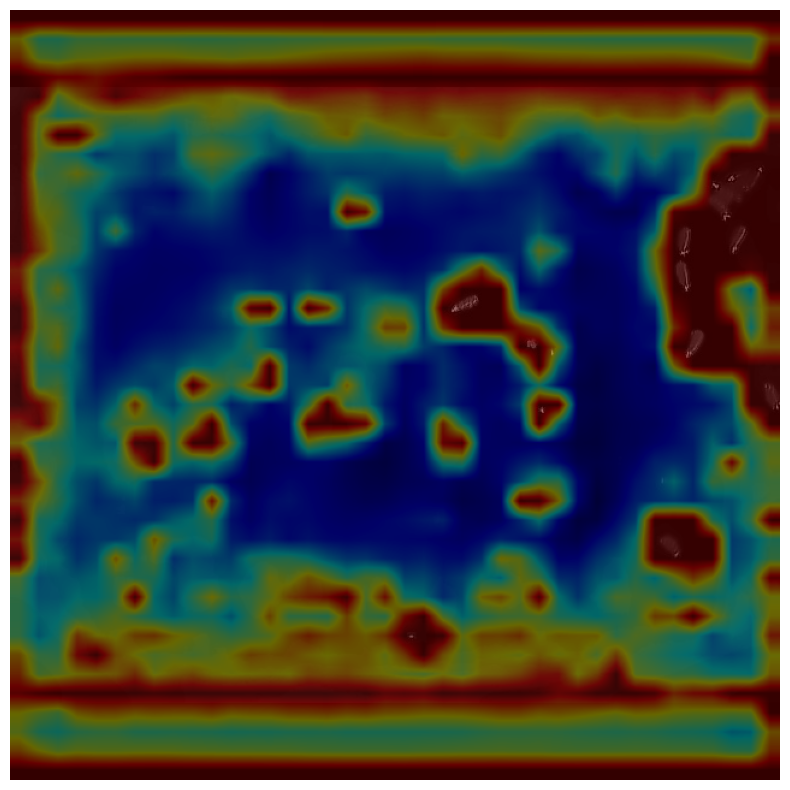

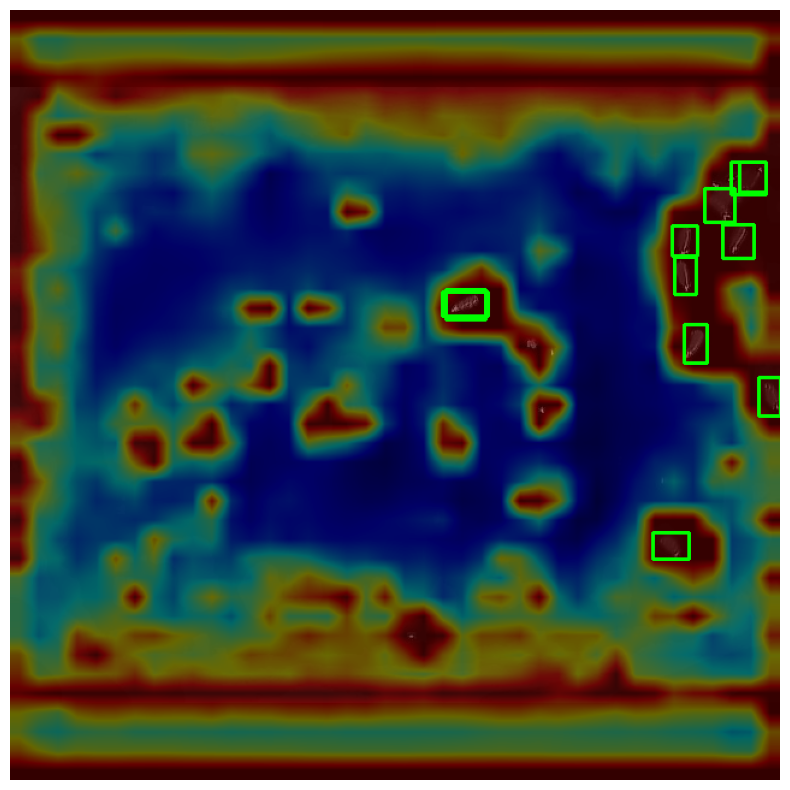

In [36]:
plt.figure(figsize=(10, 10))
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()

current_image_results = results[0] # Get results for the current image
superimposed_img_with_boxes = np.copy(superimposed_img) # Create a copy to draw on
    
for box in current_image_results.boxes.xyxy:
    x1, y1, x2, y2 = map(int, box.tolist()) # Get bounding box coordinates
    cv2.rectangle(superimposed_img_with_boxes, (x1, y1), (x2, y2), (0, 255, 0), 2) # Draw green rectangle
    
plt.figure(figsize=(10, 10))
plt.imshow(superimposed_img_with_boxes)
plt.axis('off')
plt.show()